<a href="https://colab.research.google.com/github/david-zip/Research-Project-Resources/blob/main/Deep_RL_SupplyChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supply Chain with Reinforcement Learning via policy optimisation

This notebook is a template for a supply chain optimisation, where the environment in the supply chain. The agent is currently optimised via a stochastic search algorithms.

In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import numpy.random as rnd
eps  = np.finfo(float).eps
import torch.nn.functional as F
import torch


# Supply chain environment

In [ ]:
class Multi_echelon_SupplyChain:
    
    ###########################
    # --- initializing SC --- #
    ###########################    
    def __init__(self, n_echelons, SC_params, connectivity_M='none', reward_f='none'):
        '''
        Input parameters:

        - n_echelons                        = 2                  # number of echelons
        - connectivity_M                    = [[],[]]            # Not implemented: a conectivity matrix from each echelon (only for multi product)
        - SC_params['material_cost']        = {0:12, 1:13, 2:11} # for 3 raw materials
        - SC_params['product_cost']         = {0:100, 1:300}     # for 2 products
        - SC_params['echelon_storage_cost'] = {0:5, 1:10}        # cost of storage for each echelon for 2 echelons
        - SC_params['echelon_storage_cap']  = {0:20, 1:7}        # max storage capacity for each echelon for 2 echelons
        - SC_params['echelon_prod_wt']      = {0:(5,1), 1:(7,1)} # for 2 echelons gaussian <= look at capped distributions
        - SC_params['echelon_prod_cost']    = {0:0, 1:0}         # production cost for each echelon for 2 echelons 1 product
        '''
        
        # SC variable definitions
        self.SC_params, self.n_echelons = SC_params, n_echelons
        self.connectivity_M             = connectivity_M
        self.reward_f                   = reward_f
        self.time_k                     = 0                      # time step might be important in seasonality
        self.storage_tot                = 0                      # how much storage in total there is
        self.product_tot                = 0                      # total product in the supply chain
        # reward statistics
        self.reward                     = 0                      # reward the supply chain has included
        self.r_product                  = 0                      # how much am I selling
        self.r_raw_mat                  = 0                      # how much am I spending in RM
        self.r_storage                  = 0                      # how much am I using in storage
        self.r_bakclog                  = 0                      # how much is the backlog costing me
        
        # constructing supply chain inventory
        self.wt_list = [SC_params['echelon_prod_wt'][ii][0] for ii in range(n_echelons)]
        self.max_wt  = max(self.wt_list)
        SC_inventory = np.zeros((n_echelons, self.max_wt + 1)) # (echelon, prod_wt + storage)

        # make inventory self    
        self.SC_inventory = SC_inventory
        self.warehouses   = self.SC_inventory[:,0]
        
    #############################
    # --- advance SC orders --- #
    #############################    
    
    def advance_supply_chain_orders(self, orders, demand):
        '''
        orders: np.array([raw_material=>eche_1, eche_1=>eche_2, ... , eche_n=>sale]) array of number of orders (integer value) in each echelon
        '''
        echelon_prod_wt, wt_list = self.SC_params['echelon_prod_wt'], self.wt_list # waiting times for production for each echelon
        n_echelons               = self.n_echelons
        self.time_k             += 1
    
        if self.connectivity_M == 'none':
            # minimum between orders and stored capacity
            orders_called     = orders
            orders_called[1:] = np.minimum(self.SC_inventory[:-1,0], orders[1:])  # notice first order is from raw material ('infinite')
            sales_orders      = np.minimum(self.SC_inventory[-1,0],demand)      # you cannot sell more than the demand
            orders_called     = np.hstack((orders_called,sales_orders))       # 
            # advance orders and substract from storage
            for i_eche in range(n_echelons):
                self.SC_inventory[i_eche, wt_list[i_eche]] += orders_called[i_eche]
                self.SC_inventory[i_eche, 0]               -= orders_called[i_eche+1]
            # advance all orders by 1
            for i_eche in range(n_echelons):
                shift_plus                  = copy.deepcopy(self.SC_inventory[i_eche, 1:])
                self.SC_inventory[i_eche, 0:-1] += copy.deepcopy(shift_plus[:])
                self.SC_inventory[i_eche, 1:]   -= copy.deepcopy(shift_plus[:])
            # sale orders
            sale_product = orders_called[-1]
            # update reward
            if self.reward_f == 'none':
                self.supply_chain_reward_siso(orders_called, demand)
            # extra demand that needs to be covered
            backlog = max(0, demand - orders_called[-1])
            # == return == #
            return sale_product, self.reward, backlog

    #####################################################
    # --- outputs current state of the supply chain --- #
    #####################################################

    def supply_chain_state(self):
        '''
        returns the supply chain state vector: the inventory (can be added) + time
        '''
        # import state variables
        SC_inventory_, n_echelons = copy.deepcopy(self.SC_inventory), self.n_echelons
        time_k, max_wt            = self.time_k, self.max_wt

        # reshape inventory
        SC_inventory_ = SC_inventory_.reshape((1,(max_wt+1)*n_echelons), order='F')
        # add time to state
        #SC_state = np.hstack((SC_inventory_,np.array([[time_k]])))
        SC_state  = SC_inventory_    
        # return state
        return SC_state

    ############################
    # --- reward function --- #
    ############################    
    
    def supply_chain_reward_siso(self, orders_u, demand):
        '''
        reward for single raw material and single product

        orders_u:    the orders actually done 'orders_called' which are the control actions.
        inventory_x: notice this is not the state but the inventory.
        demand     : how many sales where asked for.
        '''
        demand_penalty = self.SC_params['product_cost'][1] * 0.5 # you loose 50% extra for late product

        # check if not all demand was met
        demand_diff    = max(0, demand - orders_u[-1])
        # raw material costs 
        raw_mat_cost   = self.SC_params['material_cost'][1]*orders_u[0]
        # production gains
        product_gain   = self.SC_params['product_cost'][1] *orders_u[-1]
        # inventory - storage cost
        storage_cost   = sum([self.SC_params['echelon_storage_cost'][ii]*
                              self.SC_inventory[ii][0] for ii in range(self.n_echelons)])
        # calculate reward
        SC_reward    = product_gain - raw_mat_cost - demand_diff*demand_penalty - storage_cost
        # update reward 
        self.reward    = SC_reward
        self.r_product = product_gain
        self.r_raw_mat = raw_mat_cost
        self.r_storage = storage_cost
        self.r_bakclog = demand_diff*demand_penalty
        # update storage
        self.storage_tot = sum([self.SC_inventory[ii][0] for ii in range(self.n_echelons)])
        self.product_tot = np.sum(self.SC_inventory)
        # update warehouse values
        self.warehouses   = self.SC_inventory[:,0]








# demand functions

In [ ]:
#################################
# --- uniform random control --- #
#################################

def random_uniform_demand_si(lb, ub):
    range_ = ub - lb
    return np.random.randint(range_) + lb

#################################
# --- seasonal random control --- #
#################################

def seasonal_random_uniform_control_si(lb, ub, tk):
    range_ = ub - lb
    trend  = (np.sin(tk*365) + 1)/2
    return (np.random.randint(range_) + lb)*trend

# Simple agents

In [ ]:
###################################
# --- control and storage agent --- #
###################################

def agent_control_storage(demand, storage, n_echelon):
    orders    = np.ones(n_echelon)*demand
    if storage>2*demand:
        orders[0] = int(demand*0.8)
    return orders

# 2-Echelon SC example

## Define supply chain

In [ ]:
# define SC parameters
SC_params_ = {'echelon_storage_cost':(5/2,10/2), 'echelon_storage_cap' :(20,7),
              'echelon_prod_cost' :(0,0), 'echelon_prod_wt' :((5,1),(7,1)),
              'material_cost':{1:12}, 'product_cost':{1:100}}
n_echelons_ = 2

# build model
SC_model   = Multi_echelon_SupplyChain(n_echelons=n_echelons_, SC_params=SC_params_)

# simulation parameters
steps_tot  = 365 # int(365 * 2)
control_lb = 0; control_ub = 20
demand_lb  = 12; demand_ub = 15   
SC_model.SC_inventory[:,:] = 10
print('supply chain state = ',SC_model.supply_chain_state()[0,:].shape)

# lists for statistics
reward_history          = np.zeros((steps_tot))
backlog_history         = np.zeros((steps_tot))
demand_history          = np.zeros((steps_tot))
demand_backlog_history  = np.zeros((steps_tot))
orders_history          = np.zeros((n_echelons_, steps_tot))
warehouse_history       = np.zeros((n_echelons_, steps_tot))
# lists for statistics on reward
reward_product          = np.zeros((steps_tot))
reward_raw_mat          = np.zeros((steps_tot))
reward_storage          = np.zeros((steps_tot))
reward_bakclog          = np.zeros((steps_tot))

# initial order
order_k = np.ones(2)*(control_ub - control_lb)/2
backlog = 0
# main loop
for step_k in range(steps_tot):
    d_k_                           = random_uniform_demand_si(demand_lb, demand_ub)
    demand_history[step_k]         = d_k_
    d_k                            = d_k_ + backlog
    sale_product, r_k, backlog     = SC_model.advance_supply_chain_orders(order_k, d_k)
    reward_history[step_k]         = r_k
    backlog_history[step_k]        = backlog
    demand_backlog_history[step_k] = d_k
    # agent makes order
    order_k                        = agent_control_storage(15, SC_model.storage_tot, n_echelon=n_echelons_)
    # reward stats
    reward_product[step_k]         = SC_model.r_product
    reward_raw_mat[step_k]         = SC_model.r_raw_mat
    reward_storage[step_k]         = SC_model.r_storage
    reward_bakclog[step_k]         = SC_model.r_bakclog
    orders_history[:,step_k]       = order_k
    warehouse_history[:,step_k]    = SC_model.warehouses

print('reward = ',np.sum(reward_history))


supply chain state =  (16,)
reward =  329662.0


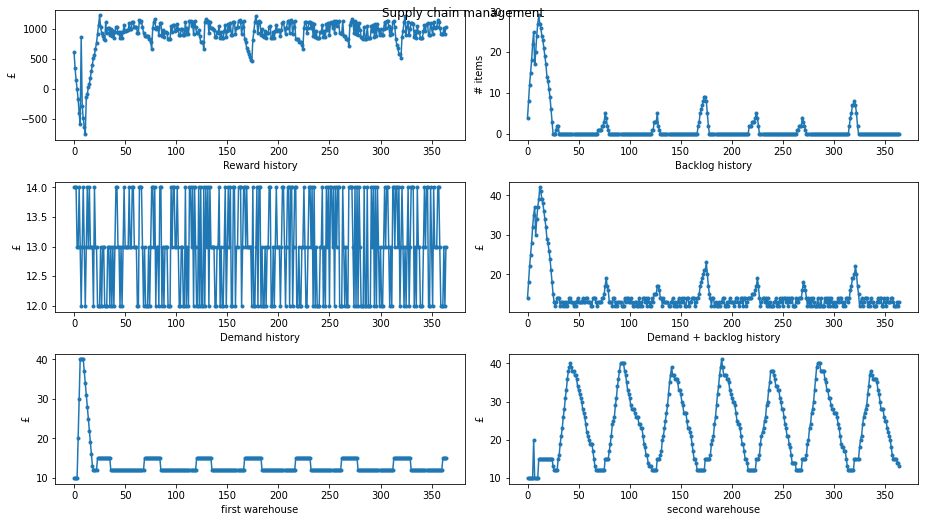

In [ ]:
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2)
fig.suptitle('Supply chain management')
fig.set_size_inches(18.5*.7, 10.5*.7)

ax1.plot(reward_history, '.-')
ax1.set_xlabel('Reward history')
ax1.set_ylabel('£')

ax2.plot(backlog_history, '.-')
ax2.set_xlabel('Backlog history')
ax2.set_ylabel('# items')

ax3.plot(demand_history, '.-')
ax3.set_xlabel('Demand history')
ax3.set_ylabel('£')

ax4.plot(demand_backlog_history, '.-')
ax4.set_xlabel('Demand + backlog history')
ax4.set_ylabel('£')

ax5.plot(warehouse_history[0,:], '.-')
ax5.set_xlabel('first warehouse')
ax5.set_ylabel('£')

ax6.plot(warehouse_history[1,:], '.-')
ax6.set_xlabel('second warehouse')
ax6.set_ylabel('£')
fig.tight_layout()


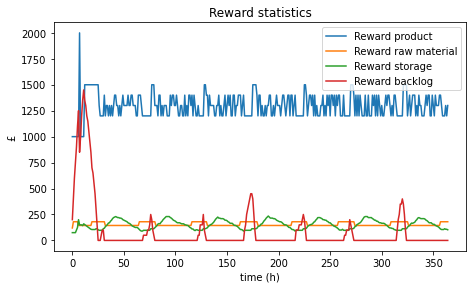

In [ ]:
fig, ax = plt.subplots(figsize=(18.5*.4, 10.5*.4))
ax.plot(reward_product, label='Reward product')  
ax.plot(reward_raw_mat, label='Reward raw material')  
ax.plot(reward_storage, label='Reward storage')  
ax.plot(reward_bakclog, label='Reward backlog')  
ax.set_xlabel('time (h)')  # Add an x-label to the axes.
ax.set_ylabel('£')  # Add a y-label to the axes.
ax.set_title("Reward statistics")  # Add a title to the axes.
ax.legend();  # Add a legend.


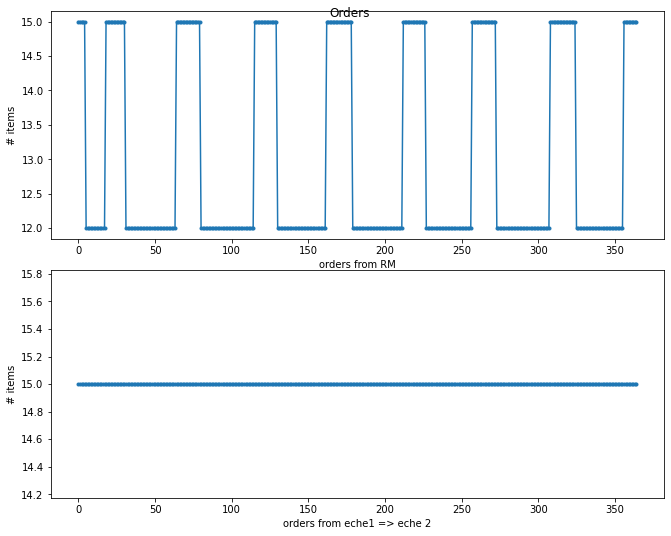

In [ ]:
fig, ([ax1, ax2]) = plt.subplots(2, 1)
fig.suptitle('Orders')
fig.set_size_inches(18.5*.5, 10.5*.7)
fig.tight_layout()

ax1.plot(orders_history[0,:], '.-')
ax1.set_xlabel('orders from RM')
ax1.set_ylabel('# items')

ax2.plot(orders_history[1,:], '.-')
ax2.set_xlabel('orders from eche1 => eche 2')
ax2.set_ylabel('# items')
#
plt.show()

# Stochastic policy search

## Policy network

In [ ]:
class Net(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
  def __init__(self, **kwargs):
    super(Net, self).__init__()

    # Unpack the dictionary 
    self.args     = kwargs
    self.dtype    = torch.float
    self.use_cuda = torch.cuda.is_available() 
    self.device   = torch.device("cpu")

    # defining ANN topology 
    self.input_size = self.args['input_size']
    self.output_sz  = self.args['output_size']
    self.hs1        = int(self.input_size/2)                                # !! parameters change manually
    self.hs2        = self.output_sz*2                                      # !! parameter  change manually

    # defining layer 
    self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
    self.output = torch.nn.Linear(self.hs2, self.output_sz)

    #self.af     = torch.nn.Tanh()

  def forward(self, x):
    x           = torch.tensor(x.view(1,1,-1)).float()
    y           = F.leaky_relu(self.hidden1(x), 0.1)
    y           = F.leaky_relu(self.hidden2(y), 0.1)
    y           = F.relu6(self.output(y))                                       # range (0,6)
    y           = y.detach().numpy()

    return np.around(y) # notice the integer rounding


## Manipulating NN weights

In [ ]:
# === Example of Neural Network evaluation === #

# defining network hyperparameters 
hyparams = {'input_size': 3,
            'output_size': 2}

# initialising the policy network
ex_net = Net(**hyparams)

# Retrieving parameters of the policy network --> returns dictionary of parameters
params = ex_net.state_dict()
#print(params)

# creating random parameters in the range [-5, 5]
params2 = {k: torch.rand(v.shape)* (5 - -5) + -5 for k, v in params.items()} 

# Updating policy parameters manually (not by backpropagation)
ex_net.load_state_dict(params2)

<All keys matched successfully>

## Functions for Generalized Policy Search

In [ ]:
def sample_uniform_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min \
              for k, v in params_prev.items()}              
    return params

def sample_local_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min + v \
              for k, v in params_prev.items()}              
    return params
# afterwards: policy.load_state_dict(params)
# note: remember dict2 = copy.deepcopy(dict1)

## Policy simulation

In [ ]:
def J_supply_chain(model, SC_run_params, data, policy, n_run):
    '''

    '''
    # problem parameters
    steps_tot  = SC_run_params['steps_tot'];  u_norm     = SC_run_params['u_norm']   
    control_lb = SC_run_params['control_lb']; control_ub = SC_run_params['control_ub']
    demand_lb  = SC_run_params['demand_lb'];  demand_lb  = SC_run_params['demand_lb']
    start_inv  = SC_run_params['start_inv'];  demand_f   = SC_run_params['demand_f'] #random_uniform_demand_si
    x_norm     = SC_run_params['x_norm']

    # se initial inventory
    model.SC_inventory[:,:] = start_inv # starting inventory
    # reward
    r_tot   = 0
    backlog = 0 # no backlog initially
    # first order
    state_norm                     = (model.supply_chain_state()[0,:] - x_norm[0])/x_norm[1]
    state_torch                    = torch.tensor((state_norm))
    order_k                        = policy(state_torch)
    order_k                        = (order_k*u_norm[0] + u_norm[1])[0,0]

    # === SC run === #
    for step_k in range(steps_tot):
        d_k_                           = 13#demand_f(demand_lb, demand_ub) #random_uniform_demand_si
        d_k                            = d_k_ + backlog
        sale_product, r_k, backlog     = model.advance_supply_chain_orders(order_k, d_k)
        r_tot                         += r_k
        # agent makes order
        state_norm                     = (model.supply_chain_state()[0,:] - x_norm[0])/x_norm[1]
        state_torch                    = torch.tensor((state_norm))
        order_k                        = policy(state_torch)
        order_k                        = (order_k*u_norm[0] + u_norm[1])[0,0]

    data['R_list'][n_run] = r_tot
    return data
     

### Policy simulation test

In [ ]:
# policy hyperparameters
hyparams_ = {'input_size': SC_model.supply_chain_state()[0,:].shape[0], 
             'output_size': 2}
# state and control actions
u_norm_   = np.array([[20/6, 20/6], [0, 0]]);  # here I am assuming entry-wise normalisation
x_norm_   = np.array([10, 10]);                # here I am assuming equal normalisation for all state entries
# run parameters
SC_run_params_ = {}
SC_run_params_['steps_tot']  = 365
SC_run_params_['control_lb'] = 0;  SC_run_params_['control_ub'] = 20
SC_run_params_['demand_lb']  = 12; SC_run_params_['demand_ub']  = 15
SC_run_params_['start_inv']  = 10; SC_run_params_['demand_f']   = random_uniform_demand_si
SC_run_params_['u_norm']     = u_norm_; SC_run_params_['x_norm']= x_norm_
SC_run_params_['hyparams']   = hyparams_

# model
SC_model = Multi_echelon_SupplyChain(n_echelons=n_echelons_, SC_params=SC_params_)
#data
data_run           = {}
data_run['R_list'] = np.zeros((1))
# initialising the policy network
policyNN  = Net(**hyparams_)

# problems run

J_supply_chain(model=SC_model, SC_run_params=SC_run_params_, data=data_run, policy=policyNN, n_run=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'R_list': array([-35515668.33333327])}

## Generalized policy search

In [ ]:
#################################
# Generalized policy search 
#################################

def Generalized_policy_search(model, SC_run_params, 
                              shrink_ratio=0.5, radius=0.1, evals_shrink=10, 
                              evals=500, ratio_ls_rs=0.7):
    '''
    Tailores to address function
    '''

    # adapt evaluations    
    evals_rs = round(evals*ratio_ls_rs)
    evals_ls = evals - evals_rs

    # problem specs
    hyparams  = SC_run_params['hyparams']

    # data
    data_rs = {}
    data_rs['R_list'] = np.zeros((evals_rs))

    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    # this can be changed manually
    param_max  =  5
    param_min  = -5
    # (-5,5)   337,155 30 => 351,304 60 =>
    # (-30,30) 317,125
    # (-10,10) 317,307 30 => 328,772 

    # == initialise rewards == #
    best_reward = -1e8
    best_policy = copy.deepcopy(params) 

    ###############
    # Random search
    ###############

    for policy_i in range(evals_rs):
        # sample a random policy
        NNparams_RS  = sample_uniform_params(params, param_max, param_min)
        # consrict policy to be evaluated
        policy_net.load_state_dict(NNparams_RS)
        # evaluate policy
        data_rs = J_supply_chain(model, SC_run_params, 
                                 data_rs, policy_net, policy_i)
        # benchmark reward ==> MAX ">"
        if data_rs['R_list'][policy_i]>best_reward:
            best_reward = data_rs['R_list'][policy_i]
            best_policy = copy.deepcopy(NNparams_RS)           

    ###############
    # local search
    ###############

    data_ls = {}
    data_ls['R_list'] = np.zeros((evals_ls))

    # define max radius
    r0 = np.array([param_min, param_max])*radius

    # initialization
    iter_i  = 0
    fail_i  = 0

    while iter_i < evals_ls:

        # shrink radius
        if fail_i >= evals_shrink:
            fail_i = 0
            radius = radius*shrink_ratio
            r0     = np.array([param_min, param_max])*radius

        # new parameters
        NNparams_LS = sample_local_params(best_policy, r0[1], r0[0])

        # == bounds adjustment == #
        # Done via ReLU6 
        
        # evaluate new agent
        policy_net.load_state_dict(NNparams_LS)
        data_ls      = J_supply_chain(model, SC_run_params, 
                                 data_ls, policy_net, iter_i)
        
        # choose the == MAX == value      
        if data_ls['R_list'][iter_i] > best_reward:
            best_reward = data_ls['R_list'][iter_i]
            best_policy = copy.deepcopy(NNparams_LS)
            fail_i = 0
        else:
            fail_i += 1

        # iteration counter
        iter_i += 1  
    print('final reward = ',best_reward)
    return best_policy, best_reward, data_rs, data_ls



In [ ]:
# problem parameters
e_tot = 5000
e_shr = e_tot/2/10
# problem specs
SC_model = Multi_echelon_SupplyChain(n_echelons=n_echelons_, SC_params=SC_params_)

best_policy, best_reward, data_rs, data_ls = \
Generalized_policy_search(SC_model, SC_run_params_, 
                              shrink_ratio=0.5, radius=0.1, evals_shrink=60, 
                              evals=5000, ratio_ls_rs=0.5)

# === Plots === #
R_full_con = np.hstack((data_rs['R_list'],data_ls['R_list']))
#R_full_con = R_full_con.T


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


final reward =  339844.99999999965


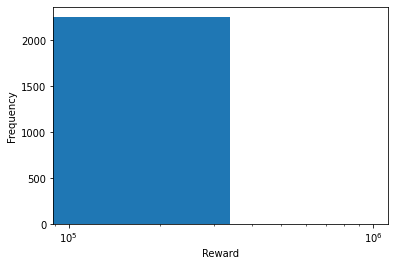

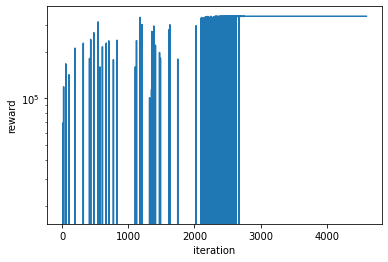

In [ ]:
plt.figure()
plt.hist(R_full_con, density=False, bins=100)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('Reward');
plt.xscale('log')

plt.figure()
plt.plot(R_full_con[400:])  # density=False would make counts
plt.ylabel('reward')
plt.xlabel('iteration');
plt.yscale('log')

## Evaluation of best policy

In [ ]:
# define SC parameters
SC_params_ = {'echelon_storage_cost':(5/2,10/2), 'echelon_storage_cap' :(20,7),
              'echelon_prod_cost' :(0,0), 'echelon_prod_wt' :((5,1),(7,1)),
              'material_cost':{1:12}, 'product_cost':{1:100}}
n_echelons_ = 2

# build model
SC_model   = Multi_echelon_SupplyChain(n_echelons=n_echelons_, SC_params=SC_params_)

# define parameters
steps_tot  = SC_run_params_['steps_tot'];  u_norm     = SC_run_params_['u_norm']   
control_lb = SC_run_params_['control_lb']; control_ub = SC_run_params_['control_ub']
demand_lb  = SC_run_params_['demand_lb'];  demand_lb  = SC_run_params_['demand_lb']
start_inv  = SC_run_params_['start_inv'];  demand_f   = SC_run_params_['demand_f'] #random_uniform_demand_si
x_norm     = SC_run_params_['x_norm']

# simulation parameters
steps_tot  = SC_run_params_['steps_tot'] 
control_lb = 0; control_ub = 20
demand_lb  = 12; demand_ub = 15   
SC_model.SC_inventory[:,:] = 10

# lists for statistics
reward_history          = np.zeros((steps_tot))
backlog_history         = np.zeros((steps_tot))
demand_history          = np.zeros((steps_tot))
demand_backlog_history  = np.zeros((steps_tot))
orders_history          = np.zeros((n_echelons_, steps_tot))
warehouse_history       = np.zeros((n_echelons_, steps_tot))
# lists for statistics on reward
reward_product          = np.zeros((steps_tot))
reward_raw_mat          = np.zeros((steps_tot))
reward_storage          = np.zeros((steps_tot))
reward_bakclog          = np.zeros((steps_tot))
# load best policy
policy_net = Net(**SC_run_params_['hyparams'])
policy_net.load_state_dict(best_policy)

# initial order
state_norm                     = (SC_model.supply_chain_state()[0,:] - x_norm[0])/x_norm[1]
state_torch                    = torch.tensor((state_norm))
order_k                        = policy_net(state_torch)
order_k                        = (order_k*u_norm[0] + u_norm[1])[0,0]

backlog = 0
# main loop
for step_k in range(steps_tot):
    d_k_                           = random_uniform_demand_si(demand_lb, demand_ub)
    demand_history[step_k]         = d_k_
    d_k                            = d_k_ + backlog
    sale_product, r_k, backlog     = SC_model.advance_supply_chain_orders(order_k, d_k)
    reward_history[step_k]         = r_k
    backlog_history[step_k]        = backlog
    demand_backlog_history[step_k] = d_k
    # agent makes order
    state_norm                     = (SC_model.supply_chain_state()[0,:] - x_norm[0])/x_norm[1]
    state_torch                    = torch.tensor((state_norm))
    order_k                        = policy_net(state_torch)
    order_k                        = (order_k*u_norm[0] + u_norm[1])[0,0]
    # reward stats
    reward_product[step_k]         = SC_model.r_product
    reward_raw_mat[step_k]         = SC_model.r_raw_mat
    reward_storage[step_k]         = SC_model.r_storage
    reward_bakclog[step_k]         = SC_model.r_bakclog
    orders_history[:,step_k]       = order_k
    warehouse_history[:,step_k]    = SC_model.warehouses





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


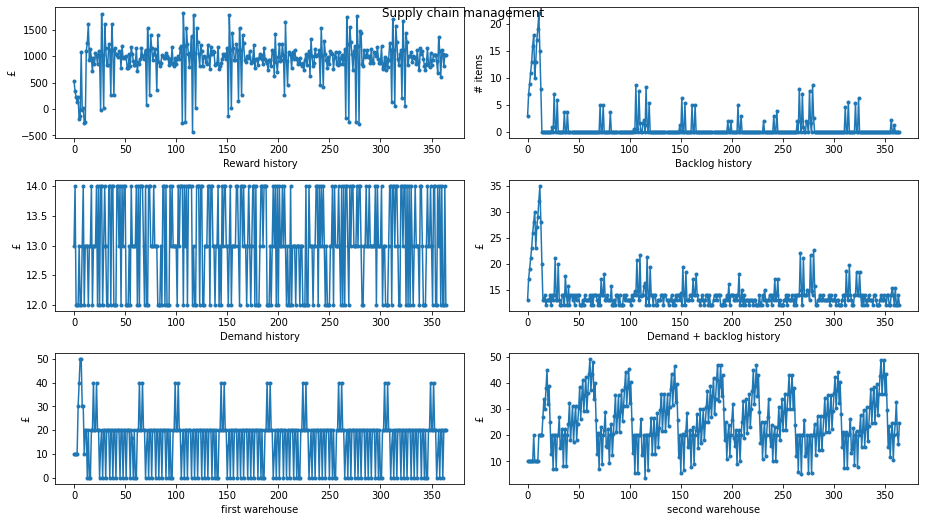

In [ ]:
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2)
fig.suptitle('Supply chain management')
fig.set_size_inches(18.5*.7, 10.5*.7)

ax1.plot(reward_history, '.-')
ax1.set_xlabel('Reward history')
ax1.set_ylabel('£')

ax2.plot(backlog_history, '.-')
ax2.set_xlabel('Backlog history')
ax2.set_ylabel('# items')

ax3.plot(demand_history, '.-')
ax3.set_xlabel('Demand history')
ax3.set_ylabel('£')

ax4.plot(demand_backlog_history, '.-')
ax4.set_xlabel('Demand + backlog history')
ax4.set_ylabel('£')

ax5.plot(warehouse_history[0,:], '.-')
ax5.set_xlabel('first warehouse')
ax5.set_ylabel('£')

ax6.plot(warehouse_history[1,:], '.-')
ax6.set_xlabel('second warehouse')
ax6.set_ylabel('£')
fig.tight_layout()


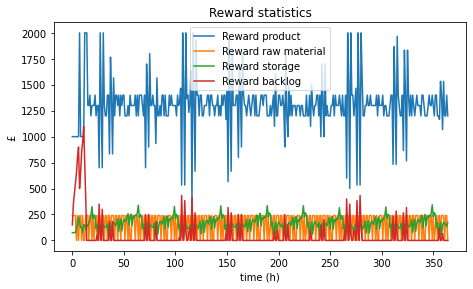

In [ ]:
fig, ax = plt.subplots(figsize=(18.5*.4, 10.5*.4))
ax.plot(reward_product, label='Reward product')  
ax.plot(reward_raw_mat, label='Reward raw material')  
ax.plot(reward_storage, label='Reward storage')  
ax.plot(reward_bakclog, label='Reward backlog')  
ax.set_xlabel('time (h)')  # Add an x-label to the axes.
ax.set_ylabel('£')  # Add a y-label to the axes.
ax.set_title("Reward statistics")  # Add a title to the axes.
ax.legend();  # Add a legend.


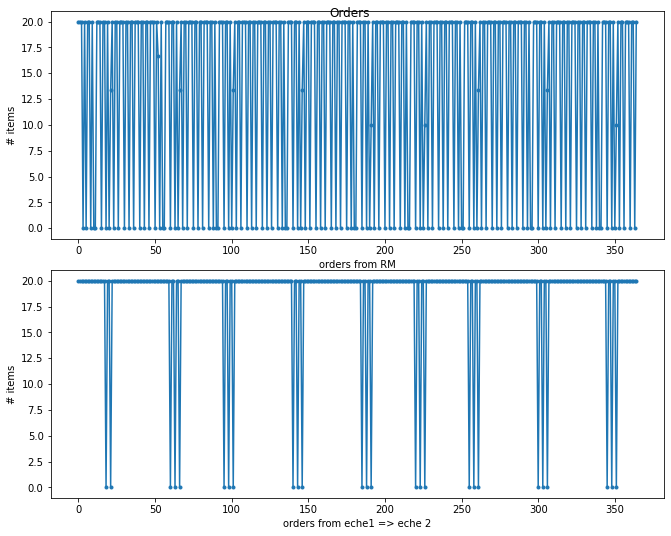

In [ ]:
fig, ([ax1, ax2]) = plt.subplots(2, 1)
fig.suptitle('Orders')
fig.set_size_inches(18.5*.5, 10.5*.7)
fig.tight_layout()

ax1.plot(orders_history[0,:], '.-')
ax1.set_xlabel('orders from RM')
ax1.set_ylabel('# items')

ax2.plot(orders_history[1,:], '.-')
ax2.set_xlabel('orders from eche1 => eche 2')
ax2.set_ylabel('# items')
#
plt.show()